# Compute Architecure - Assessment
**Course**: TU 2025 25-26: 8645 -- COMPUTER INFRASTRUCTURE  
**Lecturer**: Ian McLauglin  
**Author**: Clyde Watts  

__Summary__

The object of the Compute Architecture - Assessment , is to create a notebook ( problems.ipynb ) and an associated python script , which will export the FAANG share prices using yfinance for the last 5 business days and then load the files , and produce a report of the closing prices. 



![DataFlow](./faang_dataflow.png)




### Imports

yfinance - financial ticker data from yahoo  - [yfinance](https://github.com/ranaroussi/yfinance)
datetime - pythons inbuild date time
logging - python logging
os - operating system functions
glob - file selector

In [26]:

import logging
from datetime import datetime, timedelta
import os
import pathlib as Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns
import numpy as np
import yfinance as yf

##  Initialisation

In [27]:
# init logging
logging.basicConfig(level=logging.INFO)

In [28]:
# Delete all CSV files in the data directory
data_path = "./data/"
files = glob.glob(os.path.join(data_path, "*.csv"))
for f in files:
    print(f"Deleting file: {f}")
    os.remove(f)

Deleting file: ./data\20251129_134549.csv


### Helper Functions 




__Function: print_status__

Prints the status with a green tick or red cross. This makes it easier to validate function return codes

In [29]:





def print_status(return_code, description, return_message)-> None:
    """
    Print status with visual indicator
    
    Args:
        return_code (int): 0 for success, non-zero for failure
        description (str): Status description
        return_message (str): Related file name
    """
    if return_code == 0:
        # Green tick for success (bold)
        status_symbol = "\033[1;92m✓\033[0m"  # Bold green checkmark
    else:
        # Red X for failure (bold)
        status_symbol = "\033[1;91m✗\033[0m"  # Bold red X

    # Print entire line in bold
    print(f"\033[1m{status_symbol} Status: {return_code}, Message: {description}, File: {return_message}\033[0m")


__Smoke Test__

Check if print status will work

In [30]:
print("Smoke Test Results:")
print_status(0, "Latest file retrieval", "file_name.csv")
print_status(1, "File retrieval failed", "file_name.csv")

Smoke Test Results:
✓ Status: 0, Message: Latest file retrieval, File: file_name.csv
✗ Status: 1, Message: File retrieval failed, File: file_name.csv


__Function : diagnose_difference__

After the lecture on loading csv , and the issue of the original and loaded csv differences. I used gemeni 3 and prompted for , how would i compare the difference between the original dataframe and the exported and imported data frame in pandas

Note: 

There are alteratives to csv which do preserve the data structure , pickle or parquet. If I was implementing in production I would use parquet , or maybe invent iceberg or datalake.

In [31]:
def diagnose_differences(df_original, df_loaded)-> None:
    """
    Compares two DataFrames and prints a readable report of differences.
    """
    print("--- DIAGNOSTIC REPORT ---")
    
    # 1. Check Shape
    if df_original.shape != df_loaded.shape:
        print(f"❌ SHAPE MISMATCH: Original {df_original.shape} vs Loaded {df_loaded.shape}")
        return # Stop if shapes don't match
    else:
        print("✅ Shapes match")

    # 2. Check Index
    try:
        pd.testing.assert_index_equal(df_original.index, df_loaded.index)
        print("✅ Indices match")
    except AssertionError:
        print("❌ INDEX MISMATCH: The indices are different.")
        print(f"   Original type: {type(df_original.index)}")
        print(f"   Loaded type:   {type(df_loaded.index)}")

    # 3. Check Column Data Types (The most common CSV failure)
    print("\n--- CHECKING DTYPES ---")
    mismatches = 0
    for col in df_original.columns:
        dtype_orig = df_original[col].dtype
        dtype_load = df_loaded[col].dtype
        
        if dtype_orig != dtype_load:
            print(f"⚠️ TYPE MISMATCH in '{col}': {dtype_orig} (Original) -> {dtype_load} (Loaded)")
            mismatches += 1
    
    if mismatches == 0:
        print("✅ All data types match")

    # 4. Strict Equality Check (Values)
    print("\n--- STRICT EQUALITY ---")
    try:
        # check_dtype=False allows us to see if values match even if types don't (e.g. int vs float)
        pd.testing.assert_frame_equal(df_original, df_loaded, check_dtype=True)
        print("🎉 SUCCESS: DataFrames are identical!")
    except AssertionError as e:
        print("❌ VALUE/STRICT CHECK FAILED.")
        print("   (CSV often changes float precision or converts Ints to Floats if NaNs exist)")

# --- USAGE EXAMPLE ---

# 1. Create a complex DataFrame
df = pd.DataFrame({
    'date': pd.to_datetime(['2023-01-01', '2023-01-02']),
    'integer': [1, 2],
    'float': [1.123456789, 2.5],
    'text': ['hello', 'world']
})


__Smoke Test__

In [32]:

# 2. The "Bad" Round Trip (Standard CSV)
df.to_csv('test.csv', index=False)
df_loaded_csv = pd.read_csv('test.csv')

# 3. Run Diagnostic
diagnose_differences(df, df_loaded_csv)

# cleanup
os.remove('test.csv')

--- DIAGNOSTIC REPORT ---
✅ Shapes match
✅ Indices match

--- CHECKING DTYPES ---
⚠️ TYPE MISMATCH in 'date': datetime64[ns] (Original) -> object (Loaded)

--- STRICT EQUALITY ---
❌ VALUE/STRICT CHECK FAILED.
   (CSV often changes float precision or converts Ints to Floats if NaNs exist)


__Function: data_retention

This will cleanup data , plot and log directories old files ( older than 21 days )

In [33]:
def data_retention(old_days=21)-> tuple[int, str]:
    """
    This will cleanup data , plot and log directories old files ( older than old_days )
    
    Args:
        old_days (int): Number of days to retain files. Files older than this will be deleted.
    """
    return_code = 0
    return_message = "Data retention completed successfully."
    # Define directories to clean
    directories = ["./data/", "./plots/", "./logs/"]
    # Get current date
    now = datetime.now()
    # Calculate cutoff date
    cutoff_date = now - timedelta(days=old_days)

    for directory in directories:
        # Ensure directory exists
        Path.Path(directory).mkdir(parents=True, exist_ok=True)
        # Iterate over files in directory
        for file_path in Path.Path(directory).glob("*"):
            # Get file's last modified time
            file_mod_time = datetime.fromtimestamp(file_path.stat().st_mtime)
            # If file is older than cutoff date, delete it
            if file_mod_time < cutoff_date:
                print(f"Deleting old file: {file_path} (Last modified: {file_mod_time})")
                file_path.unlink()  # Delete the file
    return return_code,  return_message

__Smoke Test__

Check if there are any plot , data and log files older 21 days and delete

In [34]:
return_code, return_message = data_retention(old_days=21)
print_status(return_code, "Data Retention Cleanup", return_message)

✓ Status: 0, Message: Data Retention Cleanup, File: Data retention completed successfully.


## Problem 1: Data from yfinance

Using the [yfinance](https://github.com/ranaroussi/yfinance) Python package, write a function called `get_data()` that downloads all hourly data for the previous five days for the five FAANG stocks:

- Facebook (META)
- Apple (AAPL)
- Amazon (AMZN)
- Netflix (NFLX)
- Google (GOOG)

The function should save the data into a folder called `data` in the root of your repository using a filename with the format `YYYYMMDD-HHmmss.csv` where `YYYYMMDD` is the four-digit year (e.g. 2025), followed by the two-digit month (e.g. `09` for September), followed by the two digit day, and `HHmmss` is hour, minutes, seconds.
Create the `data` folder if you don't already have one.

## Problem 1: Requirements ##

### Extract ###

1.  Extract from yfinance data the stock data for META,AAPL,AMZN,NFLX,GOOG
2.  For 5 complete previous days trading , we need to take into account that NASDAQ trades from Monday to Friday. If we go back 7 days we will always ignore weekends
3.  File format will YYYYMMDD-HHmmss.csv where YYYY - is 4 digit year , MM month 01-12 , DD - is 01-31. HH - hours , 24 our clock , mm - minutes 00-59 , seconds 00-59.
4.  Grain - Hour

__Column__

- Date , <ticket> ( Open,High,Low,Close,Volume) ....
ticket is META , AAPL , AMZN , NFLX or GOOG
- Open - open price
- Close - close price
- High - High pricr
- Low - Low price
- Volumn - Volume in period

The data frame return has an index on the date , and is a multilevel index. Level one is the ticket , and the second level is the metric - that is open , close , high , low prices and volume 

Note: AI was used to generate the checklist , the author likes the style. The checklist was not used as a prompt to generate the code.

### Assignment: Problem 1 Requirements Specification

**1. Data Specification**
* [✅] Define the list of target tickers: META, AAPL, AMZN, NFLX, and GOOG.
* [✅] Define the data interval as "hourly".
* [✅] Define the data period as the "previous five days".

**2. Data Fetching**
* [✅] Use the `yfinance` Python package.
* [✅] Write code to download the data for all five tickers based on the interval and period.
* [✅] Store the downloaded data, likely in a `pandas` DataFrame.

**3. Folder Management**
* [✅] Check if a folder named `data` exists in the root of the repository.
* [✅] If the `data` folder does not exist, create it.

**4. File Output**
* [✅] Get the current date and time.
* [✅] Format the current date and time into a string `YYYYMMDD-HHmmss`.
* [✅] Create the full output path by combining the `data` folder, the formatted datetime string, and the `.csv` extension.
* [✅] Save the downloaded data DataFrame to this CSV file.



__Global Parameters__



In [35]:
# List of tickers to download
# TODO : Add a yaml config file for global parameters
tickers = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]

__Function : get_data__

This downloads the latest data for a number of listed stock companies using yfinance module and writes to CSV file. 

In [36]:

def get_data(tickers = tickers,start_date=None, end_date=None,interval="1h",data_path="./data/",once_only=True)-> tuple[int, str, str, pd.DataFrame]:
    """
    Function to get stock data from yfinance

    Parameters:
    tickers (list): List of stock tickers to download data for
    start_date (str): Start date for data in format "YYYY-MM-DD". If None, defaults to 6 days ago.
    end_date (str): End date for data in format "YYYY-MM-DD". If None, defaults to yesterday.
    interval (str): Data interval. Default is "1h".
    data_path (str): Path to save the data. Default is "./data/".
    once_only (bool): If True, download data only once for a date and do not overwrite existing files. Default is True.
    If set to false it will delete existing files and download again.
    TODO: add only once functionality
    Returns:
       return_code : 0 for success, -1 for failure
       return_message : message indicating success or failure
       file_name (str): Name of the file where data is saved
    """
    return_code = 0
    return_message = "Success"
    file_name = None
    df_data = None
    # TODO : implement once_only functionality
    # TODO : Sort out logic of start_date and end_date for once only check , simplify
    # Get current date and time and keep it constant
    now_dttm = datetime.now()
    # if start_date is None , set to today - 7 days
    start_date_dttm =(now_dttm - timedelta(days=7)) if start_date is None else datetime.strptime(start_date, "%Y-%m-%d")
    start_date = start_date_dttm.strftime("%Y-%m-%d") if start_date is None else start_date
    start_date_dttm = datetime.strptime(start_date, "%Y-%m-%d")
    # create file name from start date
    file_name = f"{data_path}{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    # create string for glob to check if file exists for start date
    start_date_glob_str = f"{data_path}{datetime.now().strftime('%Y%m%d')}*.csv"
    if once_only and glob.glob(start_date_glob_str):
        logging.info(f"File already exists for start date {start_date}, skipping download.")
        existing_files = glob.glob(start_date_glob_str)
        file_name = existing_files[0]  # Get the first matching file
        return return_code, return_message, file_name, None

        
    # if end_date is None , set to today - 0 days this means yesterday's data inclusive
    if end_date is None:
        end_date = (datetime.now() - timedelta(days=0)).strftime("%Y-%m-%d")
    else: # convert end_date to datetime object
        end_date_time = datetime.strptime(end_date, "%Y-%m-%d")
        # add 1 day to end_date to make it inclusive
        end_date = (end_date_time + timedelta(days=1)).strftime("%Y-%m-%d")
    # check if directory exists
    if not os.path.exists(data_path):
        logging.info(f"Creating directory: {data_path}")
        try:
            os.makedirs(data_path)
        except Exception as e:
            logging.error(f"Error creating directory: {e}")
            return_code = -1
            return_message = f"Error creating directory: {e}"
            return return_code, return_message, None, None
    # get start date only string for file name for once only check

    # if file exists then delete it
    if os.path.exists(file_name):
        logging.info(f"Deleting existing file: {file_name}")
        try:
            os.remove(file_name)
        except Exception as e:
            logging.error(f"Error deleting file: {e}")
            return_code = -1
            return_message = f"Error deleting file: {e}"
            return return_code, return_message, None, None
    logging.info(f"Start Date: {start_date}, End Date: {end_date}")
    try:
        df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
    except Exception as e:
        logging.error(f"Error downloading data: {e}")
        return_code = -1
        return_message = f"Error downloading data: {e}"
        return return_code, return_message, None, None
    # Save the data to a CSV file
    df_data.to_csv(file_name)
    return return_code, return_message, file_name,df_data
   



__Smoke Test__

Validate that the function works

In [37]:
print("Starting data download...")
return_code, return_message, file_name , df_data = get_data(tickers=tickers)
print_status(return_code, return_message, file_name)
# check if file exists
if return_code == 0 and file_name is not None and os.path.exists(file_name):
    print_status(0,f"Data downloaded and saved to {file_name}", file_name)
else:
    print_status(-1,"Data download failed.", None)

INFO:root:Start Date: 2025-11-22, End Date: 2025-11-29
C:\Users\cw171001\AppData\Local\Temp\ipykernel_81760\3167322178.py:73: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
[**********************60%****                   ]  3 of 5 completed

Starting data download...


[*********************100%***********************]  5 of 5 completed

✓ Status: 0, Message: Success, File: ./data/20251129_134555.csv
✓ Status: 0, Message: Data downloaded and saved to ./data/20251129_134555.csv, File: ./data/20251129_134555.csv


## Problem 2: Plotting Data

Write a function called `plot_data()` that opens the latest data file in the `data` folder and, on one plot, plots the `Close` prices for each of the five stocks.
The plot should include axis labels, a legend, and the date as a title.
The function should save the plot into a `plots` folder in the root of your repository using a filename in the format `YYYYMMDD-HHmmss.png`.
Create the `plots` folder if you don't already have one.


### Assignment: Problem 2 Requirements Specification

Here is a checklist of all the tasks the `plot_data()` function must accomplish:

**1. File Input & Data Loading**
* [✅] Access the `data` folder.
* [✅] Identify the *latest* file in the `data` folder (e.g., by checking file modification time or finding the most recent date in the filename).
* [✅] Open and read the data from this file (assuming it's a format like CSV, likely using `pandas`).

**2. Data Processing**
* [✅] Extract the `Close` price columns for all five stocks.
* [✅] Ensure the corresponding date/time data is available to be used for the x-axis.

**3. Plot Generation & Styling**
* [✅] Create a *single* plot figure.
* [✅] Plot all five `Close` price series as lines on this single plot.
* [✅] Set a clear label for the x-axis (e.g., "Date").
* [✅] Set a clear label for the y-axis (e.g., "Closing Price ($)").
* [✅] Add a legend that correctly identifies each of the five stocks.
* [✅] Get the *current* date and time.
* [✅] Set the plot's title to the current date (e.g., "Stock Prices as of YYYY-MM-DD").

**4. File Output**
* [✅] Check if a folder named `plots` exists in the root directory.
* [✅] If the `plots` folder does not exist, create it.
* [✅] Generate a filename based on the current date and time in `YYYYMMDD-HHmmss` format (e.g., `20251109-161120`).
* [✅] Save the generated plot to the `plots` folder using the generated filename with a `.png` extension.
* [✅] Ensure the plot is closed after saving to free up resources.



[glob](https://docs.python.org/3/library/glob.html)



__Function: print_status__

This prints the status. 

Clear Down Data before test

__Function : get_the_latest_file__

This scans directory ./data ( parameter ) using a pattern 20....csv to get the latest file and returns the file name

In [38]:
#------------------------------------------------------------------------------
# Function to get the latest file from a directory
#------------------------------------------------------------------------------

def get_latest_file(data_path="./data/")-> tuple[int, str, str]:
    """
    Returns the path to the latest data file in the specified directory.

    Args:
        data_path (str): The path to the directory containing the data files.

        tuple: (return_code, return_message, latest_file) where latest_file is the path to the latest data file, or None if no files are found.
        str: The path to the latest data file, or None if no files are found.
    """
    return_code = 0
    return_message = "Success"
    latest_file = None

    logging.info(f"Getting the latest file from {data_path}")
    # File pattern
    file_pattern = "20[0-9][0-9][0-1][0-9][0-3][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9].csv"
    # Add path to file pattern
    file_pattern = os.path.join(data_path, file_pattern)
    # glob searches directories for files based on a pattern
    try:
        list_of_files = glob.glob(file_pattern)
    except Exception as e:
        logging.error(f"Error occurred while searching for files: {e}")
        return_code=-1
        return_message=f"Error occurred while searching for files: {e}"
        return return_code, return_message, None
    if not list_of_files:
        logging.warning(f"No files found in {data_path} matching pattern {file_pattern}")
        return_code = -1
        return_message = f"No files found in {data_path} matching pattern {file_pattern}"
        return return_code, return_message, None
    # find the latest file based on creation time
    #    max parameters - list and function which gets "value" associated with each item in the list
    #    this gets the "youngest" file based on creation time 
    #    not necessarily the latest date in the file name - design decision 
    #    the premise is that the latest file created is the one we want to use
    latest_file = max(list_of_files, key=os.path.getctime)
    logging.info(f"Latest file: {latest_file}")
    return return_code, return_message, latest_file

__Function: get_PNG_filename_from_CSV_filename__

This function will return the png file name based on csv file name

In [39]:
def get_PNG_filename_from_CSV_filename(csv_filename,plot_path="./plots/")-> tuple[int, str, str]:
    """
    Function to get PNG filename from CSV filename

    Parameters:
    csv_filename (str): Name of the CSV file
    plot_path (str): Path to save the PNG file. Default is "./plots/".

    Returns:
       png_filename (str): Name of the PNG file
    """
    return_code = 0
    return_message = "Success"
    # extract base name from csv_filename
    base_name = os.path.basename(csv_filename)
    # remove .csv extension
    base_name = os.path.splitext(base_name)[0]
    # create png filename
    png_filename = f"{plot_path}{base_name}.png"
    return return_code, return_message, png_filename

__Smoke Test__

Run both functions , get_lastest_file and convert name from CSV to PNG

In [40]:
return_code, return_message, file_name = get_latest_file()
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {file_name}", return_message)
# now get png file name from csv file name
return_code, return_message, png_file_name = get_PNG_filename_from_CSV_filename(file_name, "./plots/")
print_status(return_code, f"PNG file path retrieval - Return Code: {return_code}, Message: {return_message}, File: {png_file_name}", return_message)


INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251129_134555.csv


✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251129_134555.csv, File: Success
✓ Status: 0, Message: PNG file path retrieval - Return Code: 0, Message: Success, File: ./plots/20251129_134555.png, File: Success


__Function : load_file_into_dataframe__

This loads the file name into data frame

In [41]:
def load_file_into_dataframe(file)-> tuple[int, str, pd.DataFrame]:
    """load_file_into_dataframe

    Args:
        file (str): The path to the data file.

    Returns:
        tuple: (return_code, return_message, df) where:
            return_code (int): 0 for success, -1 for failure
            return_message (str): Success or error message
            df (pd.DataFrame): The data as a pandas DataFrame with multi-level columns
    """
    return_code = 0
    return_message = "Success"
    df = None
    
    # Check if file name is provided
    if file is None:
        logging.error("No file provided to load into dataframe.")
        return_code = -1
        return_message = "No file provided to load into dataframe."
        return return_code, return_message, None
    
    # Check if file exists
    if not os.path.exists(file):
        logging.error(f"File does not exist: {file}")
        return_code = -1
        return_message = f"File does not exist: {file}"
        return return_code, return_message, None
    
    # Load the CSV file into a DataFrame with multi-level columns
    try:
        df = pd.read_csv(file, header=[0,1], index_col=0, parse_dates=True)
        logging.info(f"Successfully loaded data from {file}. Shape: {df.shape}")
    except Exception as e:
        logging.error(f"Error loading file {file}: {e}")
        return_code = -1
        return_message = f"Error loading file {file}: {e}"
        return return_code, return_message, None
    
    return return_code, return_message, df



__Smoke Test__

Check the following

1. Get the latest file
2. Load latest file into data frame
3. Convert CSV file name into PNG file name
4. Print Shape
5. Validate Structure

In [42]:
# Get file data before loading from csv
print("Get file data before loading from csv...")
return_code,return_message,before_file_name,df_before = get_data(tickers=tickers, once_only=False)
print_status(return_code, f"Data download before load - Return Code: {return_code}, Message: {return_message}", None)
print("Loading data from the latest file...")
return_code, return_message, latest_file = get_latest_file()
full_file_name = os.path.abspath(latest_file)
print(f"Loading data from file: {full_file_name}")
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    
print("Loading file into dataframe...")
return_code, return_message, df = load_file_into_dataframe(latest_file)
print_status(return_code, f"File load - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

print(f"Dataframe shape: {df.shape}")
# convert csv file name to png file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(latest_file, "./plots/")
print(f"PNG file path: {png_file_path}")
# calibrate structures , before and after loading from csv
diagnose_differences(df_before, df)



INFO:root:Deleting existing file: ./data/20251129_134555.csv
INFO:root:Start Date: 2025-11-22, End Date: 2025-11-29
C:\Users\cw171001\AppData\Local\Temp\ipykernel_81760\3167322178.py:73: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
[                       0%                       ]

Get file data before loading from csv...


[*********************100%***********************]  5 of 5 completed
INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251129_134555.csv
INFO:root:Successfully loaded data from ./data\20251129_134555.csv. Shape: (24, 25)


✓ Status: 0, Message: Data download before load - Return Code: 0, Message: Success, File: None
Loading data from the latest file...
Loading data from file: c:\Users\cw171001\OneDrive - Teradata\Documents\GitHub\PFDA_computer_architecture\data\20251129_134555.csv
✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251129_134555.csv, File: Success
Loading file into dataframe...
✓ Status: 0, Message: File load - Return Code: 0, Message: Success, File: ./data\20251129_134555.csv, File: Success
Dataframe shape: (24, 25)
PNG file path: ./plots/20251129_134555.png
--- DIAGNOSTIC REPORT ---
✅ Shapes match
✅ Indices match

--- CHECKING DTYPES ---
✅ All data types match

--- STRICT EQUALITY ---
🎉 SUCCESS: DataFrames are identical!


### Investigate Data Frame

Have a look at the dataframe and see it's structure. 

https://ranaroussi.github.io/yfinance/reference/api/yfinance.download.html#yfinance.download

The index is DatetimeIndex - that is the timestamp of the price.
The data appears Company/Ticker - and then metrics - open,high,low,close,volume



In [43]:
# Have a look at the index and columns
print(" Data Frame Info")
print(df.info(verbose=True))

 Data Frame Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2025-11-24 14:30:00+00:00 to 2025-11-28 16:30:00+00:00
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (AMZN, Open)    24 non-null     float64
 1   (AMZN, High)    24 non-null     float64
 2   (AMZN, Low)     24 non-null     float64
 3   (AMZN, Close)   24 non-null     float64
 4   (AMZN, Volume)  24 non-null     int64  
 5   (GOOG, Open)    24 non-null     float64
 6   (GOOG, High)    24 non-null     float64
 7   (GOOG, Low)     24 non-null     float64
 8   (GOOG, Close)   24 non-null     float64
 9   (GOOG, Volume)  24 non-null     int64  
 10  (META, Open)    24 non-null     float64
 11  (META, High)    24 non-null     float64
 12  (META, Low)     24 non-null     float64
 13  (META, Close)   24 non-null     float64
 14  (META, Volume)  24 non-null     int64  
 15  (NFLX, Open)    24 non-null     float64
 16  (NFLX, High)   

Check the first and last dates . To check if the week is being covered.
That is the fense post problem

In [44]:
# Only get the datetime index and convert to a list
datetime_index = df.index.to_series().reset_index(drop=True)
# Convert series datetime to dates and remove duplicates and sort
date_list = datetime_index.dt.date.drop_duplicates().sort_values().astype(str)
print(date_list)

0     2025-11-24
7     2025-11-25
14    2025-11-26
21    2025-11-28
Name: Datetime, dtype: object


Investigate the time zones , the data is from US NASDAQ - Monday to Friday 9:30 to 21:30 EST , UTC+8

https://www.ig.com/en/trading-strategies/nasdaq-opening-and-closing-times--when-can-you-trade--230527#:~:text=The%20index%20opens%20at%209.30,that's%204%20am%20UTC%2B8.&text=However%2C%20you%20can%20trade%20the,a%20day%2C%20Monday%20to%20Thursday.

In [45]:
# Only get the datetime index and convert to a list
datetime_index = df.index.to_series().reset_index(drop=True)
# Extract the time zone info
time_zone = datetime_index.dt.tz
print(f"Time Zone Info: {time_zone}")
# Extract time from datetime index
time_list = datetime_index.dt.time.drop_duplicates().sort_values().astype(str)
print("Time List:")
print(time_list)
# see if the convert the timezone to EST for NASDAQ data is possible
datetime_index_est = datetime_index.dt.tz_convert('US/Eastern')
print("Datetime Index in EST:")
time_list_est = datetime_index_est.dt.time.drop_duplicates().sort_values().astype(str)
print("Time List in EST:")
print(time_list_est)

Time Zone Info: UTC
Time List:
0    14:30:00
1    15:30:00
2    16:30:00
3    17:30:00
4    18:30:00
5    19:30:00
6    20:30:00
Name: Datetime, dtype: object
Datetime Index in EST:
Time List in EST:
0    09:30:00
1    10:30:00
2    11:30:00
3    12:30:00
4    13:30:00
5    14:30:00
6    15:30:00
Name: Datetime, dtype: object


In [46]:
print("Loading data from the latest file...")
return_code, return_message, latest_file = get_latest_file()
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

return_code, return_message, df = load_file_into_dataframe(latest_file)
print_status(return_code, f"File load - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

print(df.shape)
# convert csv file name to png file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(latest_file, "./plots/")
print(f"PNG file path: {png_file_path}")
return_code, return_message, df = load_file_into_dataframe(latest_file)
print(f"Function :  Return_Code = {return_code} Return Message = {return_message}")
data_path = "./data/"



INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251129_134555.csv
INFO:root:Successfully loaded data from ./data\20251129_134555.csv. Shape: (24, 25)


Loading data from the latest file...
✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251129_134555.csv, File: Success


INFO:root:Successfully loaded data from ./data\20251129_134555.csv. Shape: (24, 25)


✓ Status: 0, Message: File load - Return Code: 0, Message: Success, File: ./data\20251129_134555.csv, File: Success
(24, 25)
PNG file path: ./plots/20251129_134555.png
Function :  Return_Code = 0 Return Message = Success


In [47]:
df

Ticker                           AMZN                                      \
Price                            Open        High         Low       Close   
Datetime                                                                    
2025-11-24 14:30:00+00:00  222.580002  226.789993  222.289993  225.869995   
2025-11-24 15:30:00+00:00  225.848999  226.414993  224.869995  224.949005   
2025-11-24 16:30:00+00:00  224.929993  225.119995  224.054993  224.619995   
2025-11-24 17:30:00+00:00  224.610001  225.589996  224.589996  224.970001   
2025-11-24 18:30:00+00:00  224.960007  226.039993  224.750000  225.910004   
2025-11-24 19:30:00+00:00  225.910004  226.865005  225.470001  226.099304   
2025-11-24 20:30:00+00:00  226.085007  227.270004  225.320007  226.100006   
2025-11-25 14:30:00+00:00  226.380005  227.899994  223.800003  226.710007   
2025-11-25 15:30:00+00:00  226.690002  228.429993  226.350006  227.770004   
2025-11-25 16:30:00+00:00  227.789993  230.070007  227.580002  229.250000   
2025-11-25 17:30:00+00:00  229.259995  229.899994  229.029999  229.559998   
2025-11-25 18:30:00+00:00  229.550095  230.520004  229.369995  229.800003   
2025-11-25 19:30:00+00:00  229.800003  229.949997  228.789993  229.490005   
2025-11-25 20:30:00+00:00  229.490005  229.990005  229.139008  229.600006   
2025-11-26 14:30:00+00:00  230.740005  230.809998  228.770004  230.514999   
2025-11-26 15:30:00+00:00  230.514999  231.309998  230.119995  231.084106   
2025-11-26 16:30:00+00:00  231.099899  231.747406  230.660004  230.880005   
2025-11-26 17:30:00+00:00  230.883301  230.990005  229.440002  230.710007   
2025-11-26 18:30:00+00:00  230.724304  230.744995  229.289398  229.565002   
2025-11-26 19:30:00+00:00  229.570007  229.789993  229.044998  229.429993   
2025-11-26 20:30:00+00:00  229.419998  229.809998  229.059998  229.119995   
2025-11-28 14:30:00+00:00  231.214996  232.210007  230.229996  231.479996   
2025-11-28 15:30:00+00:00  231.479996  232.544998  231.220001  231.940002   
2025-11-28 16:30:00+00:00  231.934998  232.880005  231.869995  232.104507   

Ticker                                    GOOG                          \
Price                       Volume        Open        High         Low   
Datetime                                                                 
2025-11-24 14:30:00+00:00  8170085  310.785004  318.549988  309.400085   
2025-11-24 15:30:00+00:00  3321400  316.869995  317.750000  314.149994   
2025-11-24 16:30:00+00:00  2779034  314.500000  315.174988  311.890015   
2025-11-24 17:30:00+00:00  2147819  315.100006  318.149994  314.880005   
2025-11-24 18:30:00+00:00  2461309  317.350006  318.379913  315.540009   
2025-11-24 19:30:00+00:00  3160681  317.403015  319.000000  316.690002   
2025-11-24 20:30:00+00:00  4097764  318.040009  319.799988  317.799988   
2025-11-25 14:30:00+00:00  6943622  326.875000  328.670013  319.799988   
2025-11-25 15:30:00+00:00  2886746  327.290009  328.100006  317.816406   
2025-11-25 16:30:00+00:00  3082617  320.630005  322.179993  318.809998   
2025-11-25 17:30:00+00:00  2100070  321.369995  324.329987  320.529999   
2025-11-25 18:30:00+00:00  2146344  324.220001  324.559998  321.829987   
2025-11-25 19:30:00+00:00  2204594  323.005005  323.760010  320.929993   
2025-11-25 20:30:00+00:00  2133973  321.790009  324.470001  321.705994   
2025-11-26 14:30:00+00:00  5841042  320.779999  324.984985  317.200012   
2025-11-26 15:30:00+00:00  2659243  318.290009  320.458313  317.510010   
2025-11-26 16:30:00+00:00  2039562  319.660004  320.205994  318.489990   
2025-11-26 17:30:00+00:00  2174338  319.089996  319.790009  318.269989   
2025-11-26 18:30:00+00:00  2207386  319.630005  319.670013  318.820007   
2025-11-26 19:30:00+00:00  2275778  319.170013  319.785004  318.700012   
2025-11-26 20:30:00+00:00  2284974  319.649994  320.799988  319.500000   
2025-11-28 14:30:00+00:00  4867303  323.250000  326.880005  317.400085   
2025-11-28 15:30:00+00:00  2371103  318.119904  319.496704  316.940002

__Function : plot_data__


[set_major_locator](https://matplotlib.org/stable/api/_as_gen/matplotlib.axis.Axis.set_major_locator.html)
[set_major_formater](https://matplotlib.org/stable/api/_as_gen/matplotlib.axis.Axis.set_major_formatter.html)
[plotly mdates](https://matplotlib.org/stable/api/dates_api.html)

Gemini prompt : How do I plot unsign matplotlib a x-axis timeseries , where i can format the date time format

In [48]:
def plot_data(show_plot=False,bpi=300)-> tuple[int, str, str]:
    """plot_data

    Args:
        df (pd.DataFrame): The data as a pandas DataFrame.
        png_file_path (str): The path to save the plot image.
        bpi (int): The resolution (bits per inch) for the saved plot image.

    Returns:
        None
    """
    
    return_code = 0
    return_message = "Success"
    png_file_name = None
    # define date format string YYYY-MM-DD HH
    # date_format_str = "%m-%d %H" # Removed
    # create date formatter
    # date_formatter = plt.matplotlib.dates.DateFormatter(date_format_str) # Removed
    logging.info("Starting data plotting...")
    # Get the latest file
    return_code, return_message, png_file_name = get_latest_file()
    if return_code != 0:
        logging.error(f"Latest file retrieval failed - Return Code: {return_code}, Message: {return_message}")
        return return_code, return_message, png_file_name
    # load data into dataframe
    return_code, return_message, df_raw = load_file_into_dataframe(png_file_name)
    if return_code != 0:
        logging.error(f"File load failed - Return Code: {return_code}, Message: {return_message}, File: {png_file_name}")
        return return_code, return_message, png_file_name
    # convert csv file name to png file name
    return_code, return_message, png_file_name = get_PNG_filename_from_CSV_filename(png_file_name, "./plots/")
    if return_code != 0:
        logging.error(f"PNG file path retrieval failed - Return Code: {return_code}, Message: {return_message}, File: {png_file_path}")
        return return_code, return_message, png_file_name
    # Create plots directory if it doesn't exist
    # extract path from png_file_name
    png_path = Path.Path(png_file_name).parent 
    try:
        os.makedirs(png_path, exist_ok=True)
    except Exception as e:
        logging.error(f"Failed to create directory {png_path} - {e}")
        return 1, f"Failed to create directory {png_path}", None
    # copy dataframe to avoid modifying original
    df = df_raw.copy()
    # Convert index to EST timezone and extract date - NASDAQ data is in EST
    df['Datetime_EST'] = df.index.tz_convert('US/Eastern')
    # Extract date from datetime
    df['Date'] = df['Datetime_EST'].dt.date
    # Get start and end dates for title
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    logging.info(f"Data covers from {start_date} to {end_date}")
    # ---- Plotting ----
    fig, ax = plt.subplots()
    fig.suptitle("FAANG Stock Reports", fontsize=16)
    # Define tickers globally or pass as parameter
    if df is None or png_path is None:
        logging.error("DataFrame or PNG file path is None.")
        return
    #print(date_list)
    fig.set_size_inches(14, 8)
    for ticker in tickers:
        ax.plot(df['Datetime_EST'], df[(ticker, 'Close')], label=ticker, linestyle='-', marker='o')


    # set date ticks to 90-degree rotation for readability
    # plt.xticks(rotation=90) # Removed - Handled by autofmt_xdate
    ax.grid(True, which='both', linestyle='--', linewidth=0.5) # Updated grid
    ax.set_xlabel(' Trading Date and Time ', fontsize=12)
    ax.set_ylabel('Close Price in $', fontsize=12)
    ax.set_title(f'FAANG Stock Closing Price  From {start_date} to {end_date}', fontsize=14)
    leg = ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.get_title().set_fontsize(11)
    leg.set_title('Tickers')
    
    # Split date time into major and minor ticks
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Minor Ticks: Hours (HHh)
    # Show hours 0, 6, 12, 18. Adjust 'byhour' as needed.
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Hh'))
    
    # Rotate major labels for readability
    fig.autofmt_xdate(which='major', rotation=90)
    fig.autofmt_xdate(which='minor', rotation=90)
    

    plt.tight_layout()
    plt.savefig(png_file_name, dpi=bpi)
    if show_plot:
        plt.show()

    logging.info(f"Plot saved to {png_file_name}")
    plt.close(fig)
    return return_code, return_message, png_file_name

__Smoke Test__

Validate that the plot_data function works correctly

INFO:root:Starting data plotting...
INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251129_134555.csv
INFO:root:Successfully loaded data from ./data\20251129_134555.csv. Shape: (24, 25)
INFO:root:Data covers from 2025-11-24 to 2025-11-28


Smoke Test : Plotting


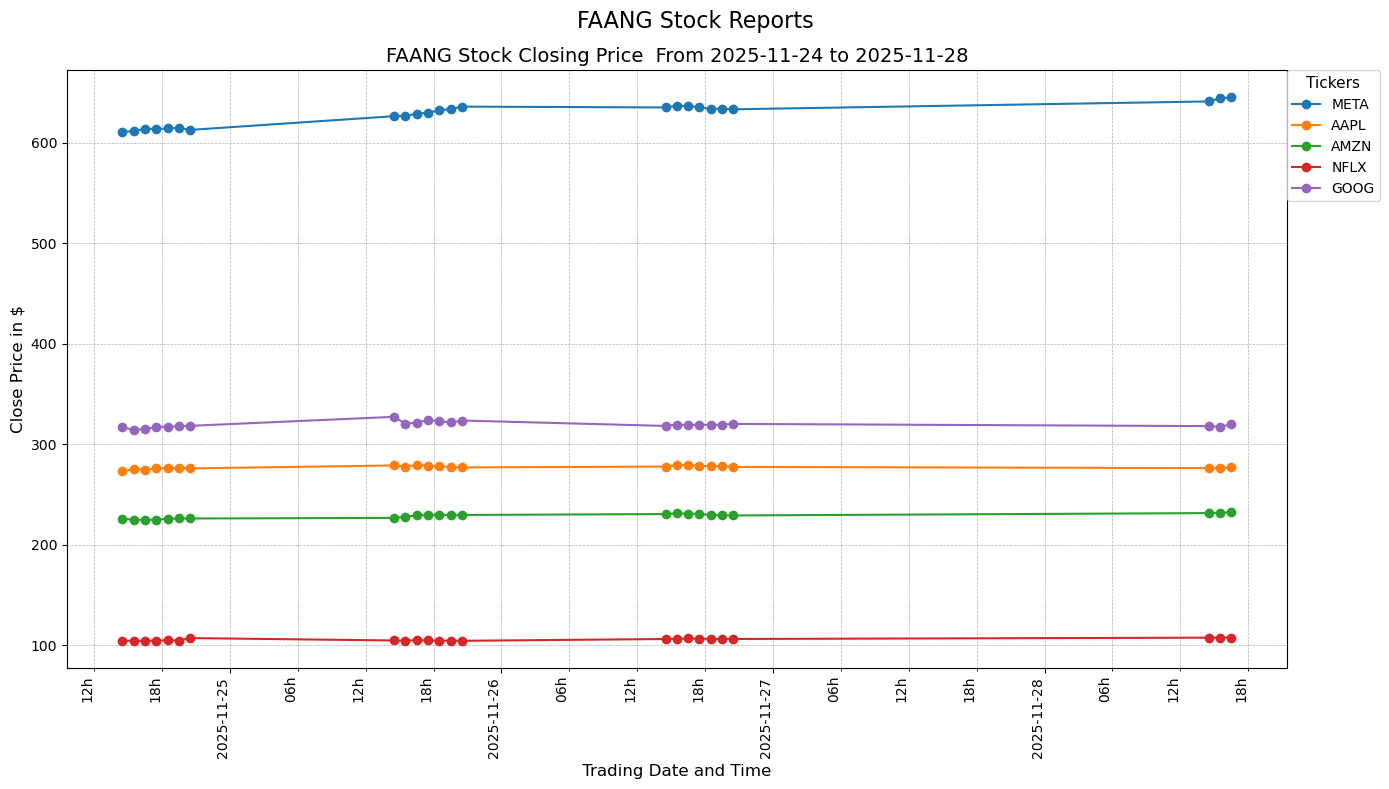

INFO:root:Plot saved to ./plots/20251129_134555.png


✓ Status: 0, Message: Plotting - Return Code: 0, Message: Success, File: ./plots/20251129_134555.png, File: Success


In [49]:
print("Smoke Test : Plotting")
return_code,return_message,filename = plot_data(show_plot=True)
print_status(return_code, f"Plotting - Return Code: {return_code}, Message: {return_message}, File: {filename}", return_message)


# Problem 3: Script #
Create a Python script called faang.py in the root of your repository. Copy the above functions into it and it so that whenever someone at the terminal types ./faang.py, the script runs, downloading the data and creating the plot. Note that this will require a shebang line and the script to be marked executable. Explain the steps you took in your notebook.

## Assignment: Problem 3 Requirements Specification##


**1. Script File Setup**

* [✅] Create a new file named faang.py.

* [✅] Ensure the file is saved in the root directory of the repository.

**2. Script Content & Structure**

* [✅] Add a "shebang" line at the very top (e.g., #!/usr/bin/env python3).

* [✅] Include all necessary import statements at the top (for yfinance, pandas, matplotlib, os, sys, etc.).

* [✅] Copy the get_data() function (from Problem 1) into the script.

* [✅] Copy the plot_data() function (from Problem 2) into the script.

* [✅] Include any helper functions needed by get_data or plot_data (like get_latest_file).

* [✅] Create a main() function to control the script's execution.

* [✅] Add the if __name__ == "__main__": block at the bottom to call the main() function.

**3. Script Execution Logic**

* [✅] Inside main(), ensure that get_data() is called first.

* [✅] Inside main(), ensure that plot_data() is called after get_data() successfully completes.

* [✅] Add error handling to stop the script if get_data() fails.

**4. Permissions & Running**

* [ ] The script must be made "executable" (using the chmod +x faang.py command in the terminal).

* [ ] The script must run successfully from the terminal when the user types ./faang.py.

**5. Documentation (Meta-Task)**

* [ ] Provide a separate explanation (e.g., in the notebook) detailing the steps taken to create the script, what the shebang line does, and how to make the script executable.

# Smoke Test

Import the "faang.py" module , and run the get_data() and plot_data() functions

INFO:root:File already exists for start date 2025-11-22, skipping download.
INFO:root:Starting data plotting...
INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251129_134555.csv
INFO:root:Successfully loaded data from ./data\20251129_134555.csv. Shape: (24, 25)
INFO:root:Data covers from 2025-11-24 to 2025-11-28


✓ Status: 0, Message: Data Retrieval - Return Code: 0, Message: Success, File: ./data\20251129_134555.csv, File: Success


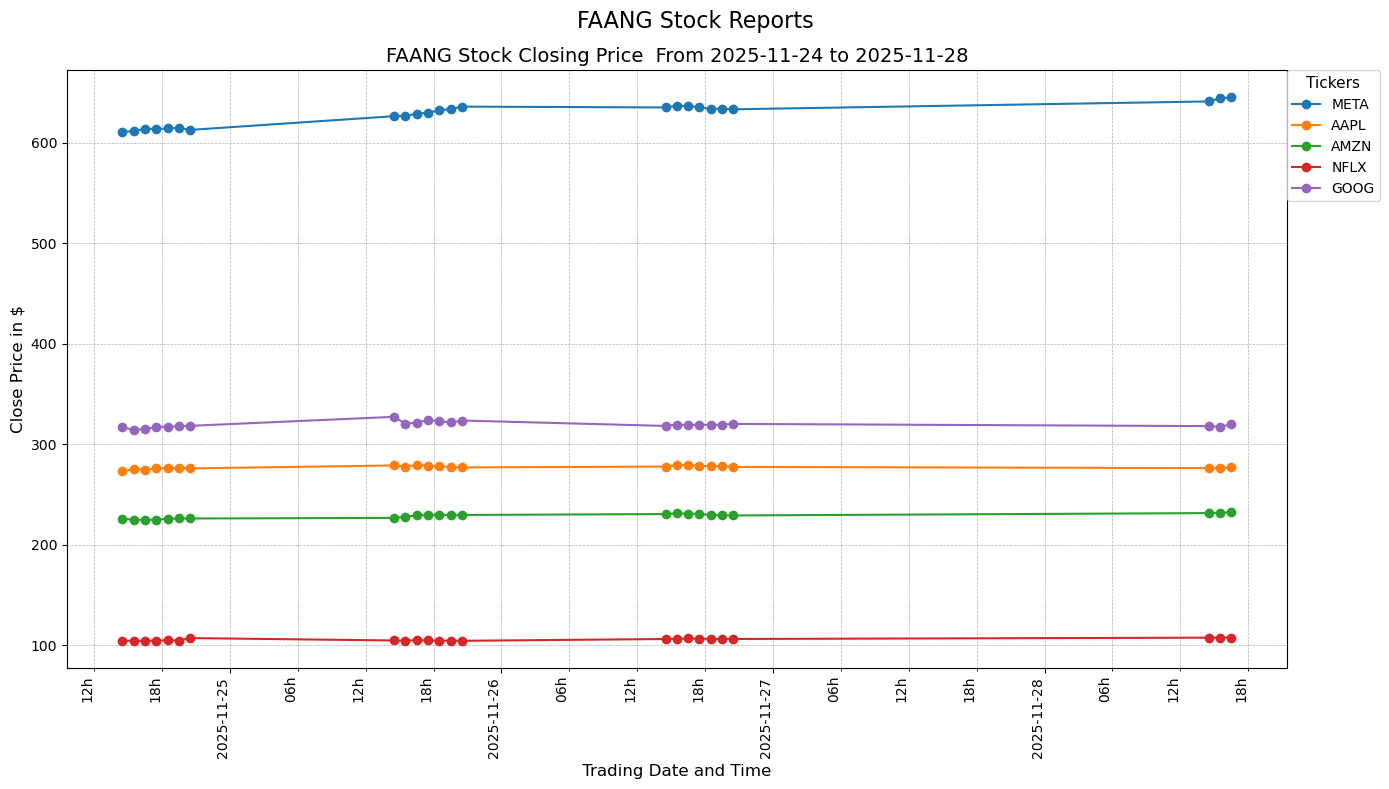

INFO:root:Plot saved to ./plots/20251129_134555.png


✓ Status: 0, Message: Plotting - Return Code: 0, Message: Success, File: ./plots/20251129_134555.png, File: Success


In [50]:
import faang as faang
# Smoke Test
# Import the "faang.py" module , and run the get_data() and plot_data() functions
return_code, return_message, file_name, df_data = faang.get_data()
print_status(return_code, f"Data Retrieval - Return Code: {return_code}, Message: {return_message}, File: {file_name}", return_message)
return_code, return_message, png_file_name = faang.plot_data(show_plot=True)
print_status(return_code, f"Plotting - Return Code: {return_code}, Message: {return_message}, File: {png_file_name}", return_message)

__The End__